In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [7]:
IMAGE_SIZE = 80
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)


In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'data/processed data/train',
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 25000 files belonging to 2 classes.


In [12]:
class_names = dataset.class_names # Takes Folder Name As Class Names
class_names

['cat', 'dog']

In [13]:
# Train test val split function
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(dataset)
    if shuffle:
        ds = ds.shuffle(shuffle_size)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    print(f'TRAIN LENGTH: {len(train_ds)} | VALIDATION LENGTH: {len(val_ds)} | TEST LENGTH: {len(test_ds)} ')
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

TRAIN LENGTH: 625 | VALIDATION LENGTH: 78 | TEST LENGTH: 79 


In [14]:
"""
CACHE WILL SAVE IMG IN MEMORY FOR NEXT EPOCH AND
PREFETCH : IF GPU BUSY IN TRAINING THEN CPU WILL LOAD THE NEXT BATCH
"""
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
n_classes = len(class_names)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(INPUT_SHAPE)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 80, 80, 3)           0         
                                                                 
 sequential_1 (Sequential)   (32, 80, 80, 3)           0         
                                                                 
 conv2d (Conv2D)             (32, 78, 78, 32)          896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 39, 39, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 37, 37, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 18, 18, 64)         0         
 2D)                                                  

In [19]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [20]:
device = 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'
print(f'Device under use for training: {device}')

with tf.device(device):
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=val_ds
    )

Device under use for training: GPU
Epoch 1/50
625/625 [==============================] - 54s 39ms/step - loss: 0.6616 - accuracy: 0.5899 - val_loss: 0.6422 - val_accuracy: 0.6286
Epoch 2/50
625/625 [==============================] - 6s 10ms/step - loss: 0.5995 - accuracy: 0.6769 - val_loss: 0.5877 - val_accuracy: 0.6999
Epoch 3/50
625/625 [==============================] - 6s 10ms/step - loss: 0.5638 - accuracy: 0.7080 - val_loss: 0.5299 - val_accuracy: 0.7468
Epoch 4/50
625/625 [==============================] - 6s 9ms/step - loss: 0.5412 - accuracy: 0.7291 - val_loss: 0.5294 - val_accuracy: 0.7352
Epoch 5/50
625/625 [==============================] - 6s 9ms/step - loss: 0.5251 - accuracy: 0.7407 - val_loss: 0.5470 - val_accuracy: 0.7252
Epoch 6/50
625/625 [==============================] - 6s 9ms/step - loss: 0.5088 - accuracy: 0.7508 - val_loss: 0.4790 - val_accuracy: 0.7796
Epoch 7/50
625/625 [==============================] - 6s 9ms/step - loss: 0.4896 - accuracy: 0.7631 - val_los

In [21]:
scores = model.evaluate(test_ds)

79/79 [==============================] - 19s 7ms/step - loss: 0.2960 - accuracy: 0.8726


In [22]:
model_version = "model_train_7"
model.save(f'models/{model_version}')

Text(0.5, 1.0, 'Training and Validation Loss')

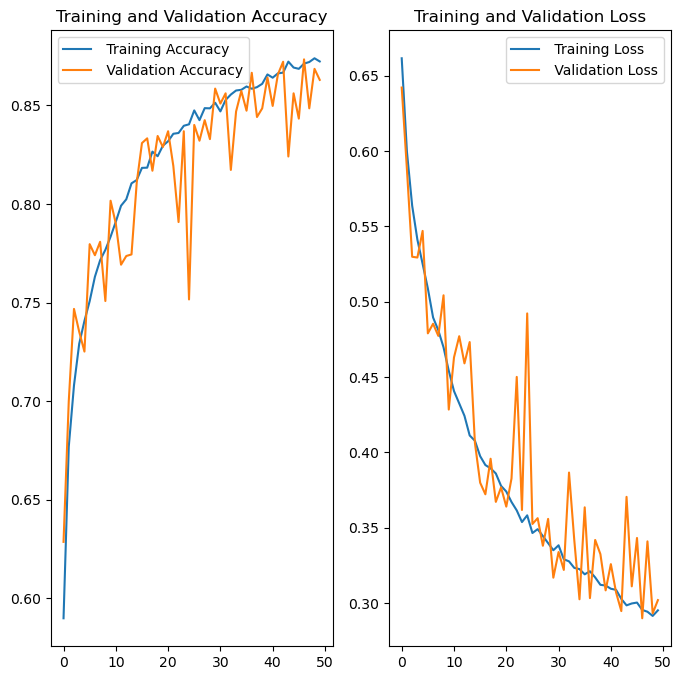

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = ' Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = ' Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = ' Training Loss')
plt.plot(range(EPOCHS), val_loss, label = ' Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')